# This jupyter notebook contains a basic example of
- how to cluster and (potentially) select REX structure ensembles from a contact-guided REX simulation

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pyrexMD.misc as misc
import pyrexMD.core as core
import pyrexMD.topology as top
import pyrexMD.analysis.analysis as ana
import pyrexMD.analysis.contacts as con
import pyrexMD.analysis.gdt as gdt
import pyrexMD.decoy.cluster as clu
import MDAnalysis as mda
import os

from tqdm.notebook import tqdm
misc.apply_matplotlib_rc_settings()

In [2]:
### general steps
# 1) pre-filter REX trajectory based on task-specific criteria (e.g. QBias, QNative, Energies...)
# 2) calculate distance matrices for filtered frames
# 3) cluster filtered frames

In [3]:
### starting at step 3) and using unpublished sample data

# load data
QBias = misc.pickle_load("./files/cluster/QBias.pickle")
RMSD = misc.pickle_load("./files/cluster/RMSD.pickle")
GDT_TS = misc.pickle_load("./files/cluster/GDT_TS.pickle")

score_file = "./files/cluster/energies.log"
ENERGY = misc.read_file(score_file, usecols=1, skiprows=1)
DM = clu.read_h5("./files/cluster/DM.h5")

In [4]:
### apply TSNE for dimension reduction
tsne = clu.apply_TSNE(DM, n_components=2, perplexity=50, random_state=1)

### apply KMeans on TSNE-transformed data (two variants with low and high cluster number)
# here: high number set only to 20 because we look at small samle size with 500 frames

cluster10 = clu.apply_KMEANS(tsne, n_clusters=10, random_state=1)
cluster20 = clu.apply_KMEANS(tsne, n_clusters=20, random_state=1)

In [5]:
### map scores (energies) and accuracy (GDT, RMSD) to clusters
cluster10_scores = clu.map_cluster_scores(cluster_data=cluster10, score_file=score_file)
cluster10_accuracy = clu.map_cluster_accuracy(cluster_data=cluster10, GDT=GDT_TS, RMSD=RMSD)

cluster20_scores = clu.map_cluster_scores(cluster_data=cluster20, score_file=score_file)
cluster20_accuracy = clu.map_cluster_accuracy(cluster_data=cluster20, GDT=GDT_TS, RMSD=RMSD)

<IPython.core.display.Javascript object>


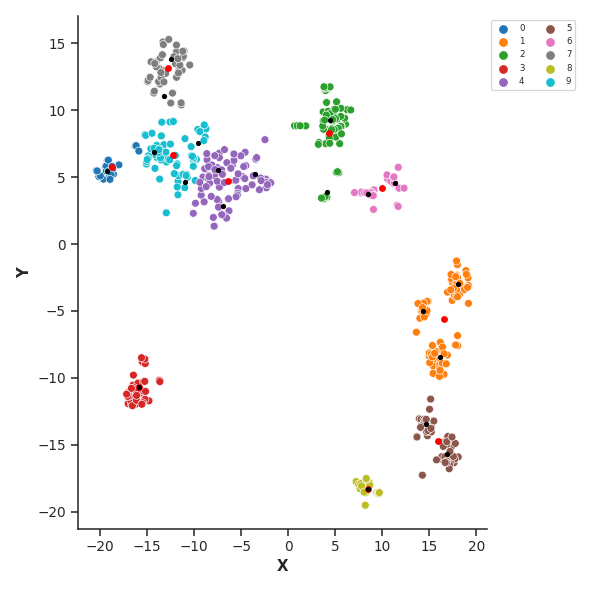

In [6]:
### plot cluster data
# here: TSNE-transformed data with n_clusters = 10
# also: plot cluster centers with different colors 
#     - red dot: n20 centers
#     - black dot: n10 centers

clu.plot_cluster_data(cluster10, tsne, ms=40)
clu.plot_cluster_center(cluster10, marker="o", color="red", ms=20)
clu.plot_cluster_center(cluster20, marker="o", color="black")

<IPython.core.display.Javascript object>


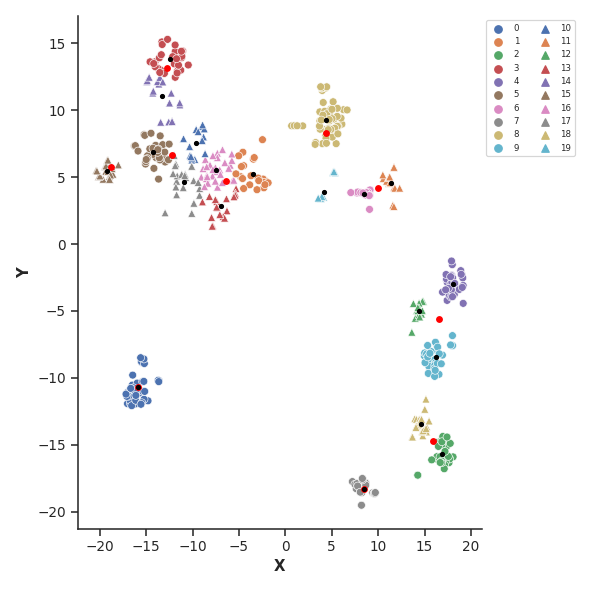

In [7]:
### plot cluster data
# here: TSNE-transformed data with n_clusters = 20
# also: plot cluster centers with different colors 
#     - red dot: n20 centers
#     - black dot: n10 centers

clu.plot_cluster_data(cluster20, tsne)
clu.plot_cluster_center(cluster10, marker="o", color="red", ms=20)
clu.plot_cluster_center(cluster20, marker="o", color="black")

In [8]:
### print table with cluster scores stats

_ = clu.WF_print_cluster_scores(cluster_data=cluster10, cluster_scores=cluster10_scores, 
                                score_file=score_file)
print("-------------------------------------------------------------------")
_ = clu.WF_print_cluster_scores(cluster_data=cluster20, cluster_scores=cluster20_scores, 
                                score_file=score_file)

cluster n10 scores (ranked by Emean)

ndx  size  compact | Emean    Estd    Emin      Emax      DELTA
  4   77     6.695 |-230.652  6.975  -246.249  -211.738  -7.67 
  2   64      6.92 |-226.558  9.827  -249.136  -201.079  -3.576
  9   61      5.78 |-226.274  8.08   -241.86   -209.002  -3.292
  7   43     3.098 |-225.174  7.679  -242.951  -206.42   -2.192
  5   53     3.441 |-223.03   6.056  -237.002  -209.372  -0.048
  0   25     2.172 |-220.319  7.431  -231.002  -203.796   2.663 
  6   29     2.904 |-218.603  16.489  -246.674  -190.634   4.379 
  1   80     9.121 |-216.962  7.09   -235.155  -200.969   6.02  
  8   25     0.798 |-214.371  6.688  -228.33   -201.657   8.611 
  3   43      1.91 |-194.022  2.585  -198.461  -190.412   28.96 
-------------------------------------------------------------------
cluster n20 scores (ranked by Emean)

ndx  size  compact | Emean    Estd    Emin      Emax      DELTA
 19   12     1.115 |-236.354  12.82  -249.136  -201.079  -13.372
  1   22     2.13

In [9]:
### print table with cluster accuracy stats

_ = clu.WF_print_cluster_accuracy(cluster_data=cluster10, accuracy_data=cluster10_accuracy)
print("---------------------------------------------------------------------------------")
_ = clu.WF_print_cluster_accuracy(cluster_data=cluster20, accuracy_data=cluster20_accuracy)

cluster n10 accuracy (ranked by GDT mean)

                   | GDT     GDT    GDT     GDT    | RMSD   RMSD   RMSD   RMSD
ndx  size  compact | mean    std    min     max    | mean   std    min    max
  2    64     6.92 | 78.373  2.883  73.81   85.418 | 2.566  0.166  2.09   3.076
  4    77    6.695 | 77.003  2.451  63.69   82.44  | 2.804  0.096  2.62   3.154
  9    61     5.78 | 75.943  2.325  71.728  82.142 | 2.85   0.096  2.567  3.03 
  7    43    3.098 | 74.821  2.017  70.538  79.763 | 2.895  0.096  2.696  3.19 
  6    29    2.904 | 69.376  15.771 41.37   94.94  | 2.979  1.398  0.996  6.501
  0    25    2.172 | 68.941  2.312  65.177  74.407 | 3.091  0.104  2.796  3.221
  1    80    9.121 | 64.695  3.943  55.057  74.703 | 3.444  0.238  2.719  3.896
  5    53    3.441 | 63.235  1.766  58.927  66.668 | 3.498  0.132  3.079  3.721
  8    25    0.798 | 60.012  2.289  56.248  63.69  | 3.804  0.087  3.684  4.043
  3    43     1.91 | 55.621  2.013  51.785  60.715 | 4.312  0.17   3.794  4.798


In [10]:
# based on initial filtering and setup of energy function it is possible to "guess" 
# good structure ensembles and verify selections based on accuracy stats